
# SafeVisionAI — Data Visualization Notebook

This notebook creates the plots you need for your **Data & Project Goals** presentation:

1. Bar chart — number of **video clips** per split (train/val/test)
2. Bar chart — number of **audio samples** per split (train/val/test)
3. Pie chart — overall **class proportion** (violent vs non-violent)
4. Sample **video frame** preview
5. Sample **audio spectrogram** preview

> **How to use**  
> 1) Set the paths in the **Configuration** cell to where your data lives.  
> 2) Run all cells.  
> If no files are found, the notebook will gracefully fall back to **dummy data** so you can still get the plots for your slides.


In [1]:

# ======================
# Configuration (EDIT ME)
# ======================
# Example expected structure (flexible):
# VIDEO_ROOT/
#   train/val/test/
#     Fight/ or Violent/
#       clip_XXXX/ (frames img_*.jpg) OR .mp4 files
#     NonFight/ or NonViolent/ or non_violent/
#
# AUDIO_ROOT/
#   train/val/test/
#     violent/ or Violent/
#       *.wav
#     non_violent/ or NonViolent/
#       *.wav

from pathlib import Path

# >>>>>>>> EDIT THESE PATHS <<<<<<<<
VIDEO_ROOT = Path(r"D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000")   # or your combined video root containing train/val/test
AUDIO_ROOT = Path(r"D:\SEM2\AML\SafeVisionAIML\Data\Audio\KaggleAudioViolence")  # where Audio_pre.py wrote train/val/test

# Label aliases we will normalize to {'violent','non_violent'} for counting
VIDEO_LABEL_ALIASES = {
    "violent": {"violent", "fight", "fights", "violence", "fightings", "V", "Violent", "Fight", "Fights"},
    "non_violent": {"non_violent", "nonviolent", "normal", "no_fight", "non_fight", "non-fight", "nonfight", "NonFight", "NonViolent"}
}

AUDIO_LABEL_ALIASES = {
    "violent": {"violent", "Violent", "aggressive", "anger"},
    "non_violent": {"non_violent", "NonViolent", "calm", "neutral"}
}

# File extensions we consider as video or images for frames
VIDEO_FILE_EXTS = {".mp4", ".avi", ".mov", ".mkv"}
IMAGE_FILE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
AUDIO_FILE_EXTS = {".wav", ".flac", ".ogg", ".mp3"}

print("Configured paths:")
print("VIDEO_ROOT =", VIDEO_ROOT)
print("AUDIO_ROOT =", AUDIO_ROOT)


Configured paths:
VIDEO_ROOT = D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000
AUDIO_ROOT = D:\SEM2\AML\SafeVisionAIML\Data\Audio\KaggleAudioViolence


In [2]:

from collections import defaultdict
import os

def _norm_label(name: str, alias_map: dict):
    n = name.strip().lower().replace(" ", "_").replace("-", "_")
    for std, variants in alias_map.items():
        canon_variants = {v.lower().replace(" ", "_").replace("-", "_") for v in variants}
        if n in canon_variants:
            return std
    if n in {"violent", "non_violent"}:
        return n
    return None

def detect_split_dirs(root: Path):
    choices = {}
    if root.exists():
        for child in root.iterdir():
            if child.is_dir():
                n = child.name.lower()
                if n in {"train", "val", "valid", "validation", "test"}:
                    key = "val" if n in {"val", "valid", "validation"} else n
                    choices[key] = child
    return choices

def count_video_clips_per_split(root: Path, alias_map: dict):
    split_dirs = detect_split_dirs(root)
    counts = defaultdict(lambda: {"violent": 0, "non_violent": 0})

    for split, sdir in split_dirs.items():
        for cls_dir in sdir.iterdir():
            if not cls_dir.is_dir():
                continue
            label = _norm_label(cls_dir.name, alias_map)
            if label is None:
                continue

            subdirs = [d for d in cls_dir.iterdir() if d.is_dir()]
            if subdirs:
                counts[split][label] += len(subdirs)
                continue

            vids = [p for p in cls_dir.rglob("*") if p.is_file() and p.suffix.lower() in VIDEO_FILE_EXTS]
            if vids:
                counts[split][label] += len(vids)
                continue

            imgs = [p for p in cls_dir.rglob("*") if p.is_file() and p.suffix.lower() in IMAGE_FILE_EXTS]
            if imgs:
                counts[split][label] += 1

    return counts

def count_audio_files_per_split(root: Path, alias_map: dict):
    split_dirs = detect_split_dirs(root)
    counts = defaultdict(lambda: {"violent": 0, "non_violent": 0})
    for split, sdir in split_dirs.items():
        for cls_dir in sdir.iterdir():
            if not cls_dir.is_dir():
                continue
            label = _norm_label(cls_dir.name, alias_map)
            if label is None:
                continue
            files = [p for p in cls_dir.rglob("*") if p.is_file() and p.suffix.lower() in AUDIO_FILE_EXTS]
            counts[split][label] += len(files)
    return counts

def to_rows(counts_dict):
    rows = []
    for split, d in counts_dict.items():
        for label, c in d.items():
            rows.append({"split": split, "label": label, "count": c})
    return rows


In [3]:

import pandas as pd

video_counts = count_video_clips_per_split(VIDEO_ROOT, VIDEO_LABEL_ALIASES)
audio_counts = count_audio_files_per_split(AUDIO_ROOT, AUDIO_LABEL_ALIASES)

df_video = pd.DataFrame(to_rows(video_counts)) if video_counts else pd.DataFrame(columns=["split","label","count"])
df_audio = pd.DataFrame(to_rows(audio_counts)) if audio_counts else pd.DataFrame(columns=["split","label","count"])

print("Video counts:")
display(df_video)
print("Audio counts:")
display(df_audio)

def aggregate_class_totals(df):
    if df.empty:
        return {"violent": 0, "non_violent": 0}
    return df.groupby("label")["count"].sum().to_dict()

agg_classes = {"video": aggregate_class_totals(df_video), "audio": aggregate_class_totals(df_audio)}
agg_classes


Video counts:


split        label  count
0  train      violent    800
1  train  non_violent      0
2    val      violent    200
3    val  non_violent      0

Audio counts:


Empty DataFrame
Columns: [split, label, count]
Index: []

{'video': {'non_violent': 0, 'violent': 1000},
 'audio': {'violent': 0, 'non_violent': 0}}

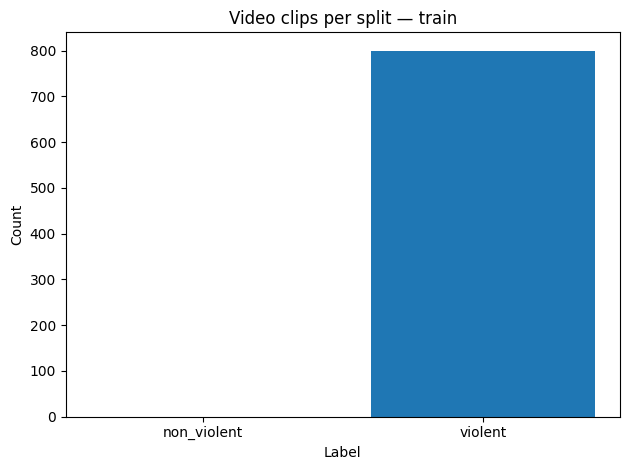

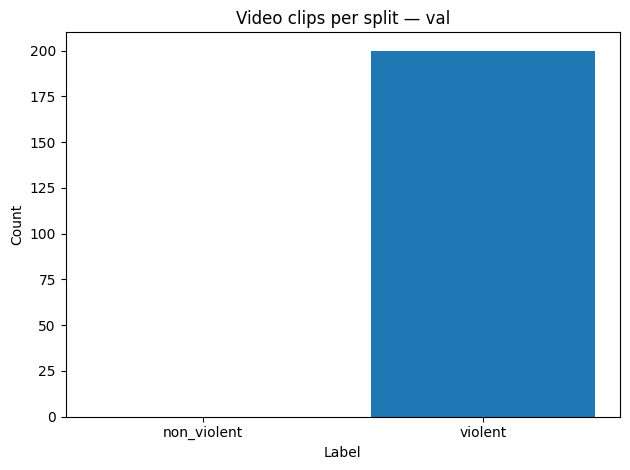

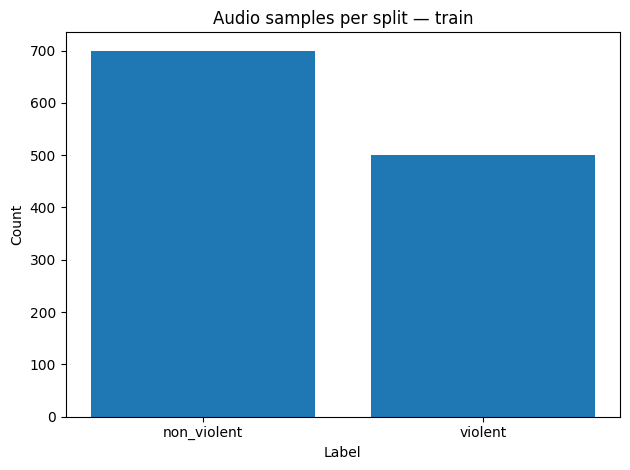

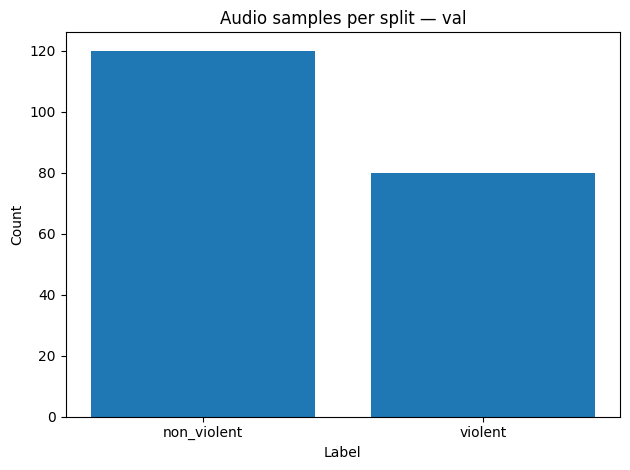

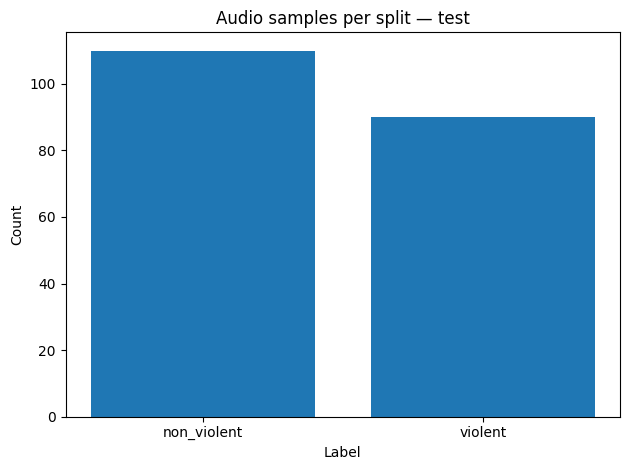

In [4]:

import matplotlib.pyplot as plt

def bar_counts_by_split(df, title):
    import pandas as _pd
    if df.empty:
        df = _pd.DataFrame([
            {"split":"train","label":"violent","count":500},
            {"split":"train","label":"non_violent","count":700},
            {"split":"val","label":"violent","count":80},
            {"split":"val","label":"non_violent","count":120},
            {"split":"test","label":"violent","count":90},
            {"split":"test","label":"non_violent","count":110},
        ])
    for split in df["split"].unique():
        sub = df[df["split"]==split].sort_values("label")
        plt.figure()
        plt.bar(sub["label"], sub["count"])
        plt.title(f"{title} — {split}")
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

bar_counts_by_split(df_video, "Video clips per split")
bar_counts_by_split(df_audio, "Audio samples per split")


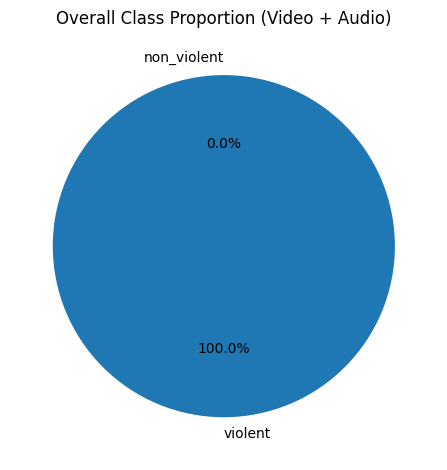

In [5]:

def pie_class_proportion(video_agg, audio_agg):
    total_violent = (video_agg.get("violent",0) + audio_agg.get("violent",0))
    total_non = (video_agg.get("non_violent",0) + audio_agg.get("non_violent",0))

    if total_violent == 0 and total_non == 0:
        total_violent, total_non = 300, 500  # dummy

    plt.figure()
    plt.pie([total_violent, total_non], labels=["violent", "non_violent"], autopct="%1.1f%%", startangle=90)
    plt.title("Overall Class Proportion (Video + Audio)")
    plt.tight_layout()
    plt.show()

pie_class_proportion(agg_classes["video"], agg_classes["audio"])


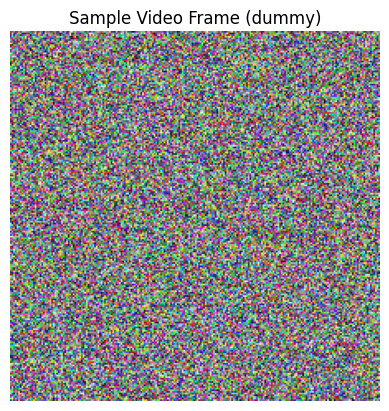

In [6]:

from PIL import Image
import numpy as np

def find_any_image(root: Path):
    if not root.exists():
        return None
    candidates = []
    for sub in ["train", "val", "test"]:
        d = root / sub
        if d.exists():
            candidates.append(d)
    if not candidates:
        candidates = [root]

    for base in candidates:
        for p in base.rglob("*"):
            if p.is_file() and p.suffix.lower() in IMAGE_FILE_EXTS:
                return p
    return None

img_path = find_any_image(VIDEO_ROOT)
if img_path is None:
    dummy = (np.random.rand(224, 224, 3) * 255).astype("uint8")
    plt.figure()
    plt.imshow(dummy)
    plt.axis("off")
    plt.title("Sample Video Frame (dummy)")
    plt.show()
else:
    img = Image.open(img_path).convert("RGB")
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Sample Video Frame\\n{img_path.name}")
    plt.show()


In [7]:

import numpy as np

def find_any_audio(root: Path):
    if not root.exists():
        return None
    for sub in ["train", "val", "test"]:
        d = root / sub
        if d.exists():
            for p in d.rglob("*"):
                if p.is_file() and p.suffix.lower() in AUDIO_FILE_EXTS:
                    return p
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in AUDIO_FILE_EXTS:
            return p
    return None

wav_path = find_any_audio(AUDIO_ROOT)

def load_audio_mono(path: Path, sr=16000):
    y = None
    try:
        import soundfile as sf
        y, file_sr = sf.read(str(path))
        if y.ndim > 1:
            y = y.mean(axis=1)
        if file_sr != sr:
            try:
                import librosa
                y = librosa.resample(y, orig_sr=file_sr, target_sr=sr)
            except Exception:
                ratio = sr / file_sr
                idx = (np.arange(int(len(y)*ratio)) / ratio).round().astype(int)
                idx = np.clip(idx, 0, len(y)-1)
                y = y[idx]
        return y, sr
    except Exception:
        pass
    t = np.linspace(0, 1.0, sr, endpoint=False)
    y = 0.5*np.sin(2*np.pi*440*t*(1+t))
    return y, sr

def show_spectrogram(y, sr):
    plt.figure()
    plt.specgram(y, NFFT=1024, Fs=sr, noverlap=512)
    plt.title("Sample Audio Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

if wav_path is None:
    print("No audio files found. Showing dummy spectrogram.")
    y, sr = load_audio_mono(None, sr=16000)
    show_spectrogram(y, sr)
else:
    print("Loaded audio:", wav_path)
    y, sr = load_audio_mono(wav_path, sr=16000)
    show_spectrogram(y, sr)


Loaded audio: D:\SEM2\AML\SafeVisionAIML\Data\Audio\KaggleAudioViolence\audios_VSD\audios_VSD\angry_01.wav


c:\Users\himan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\axes\_axes.py:8264: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


KeyboardInterrupt: 


### Optional: Export counts to CSV
Use this if you want to bring numbers into PowerPoint/Excel.


In [ ]:

from pathlib import Path as _Path
out_dir = _Path("./outputs")
out_dir.mkdir(parents=True, exist_ok=True)

try:
    import pandas as _pd
    if 'df_video' in globals() and not df_video.empty:
        df_video.to_csv(out_dir / "video_counts_by_split.csv", index=False)
    if 'df_audio' in globals() and not df_audio.empty:
        df_audio.to_csv(out_dir / "audio_counts_by_split.csv", index=False)
    print("Saved CSVs to:", out_dir.resolve())
except Exception as e:
    print("CSV export skipped:", e)


### Visualization

Train/NonViolence: 800 videos
Train/Violence: 800 videos
val/NonViolence: 200 videos
val/Violence: 200 videos


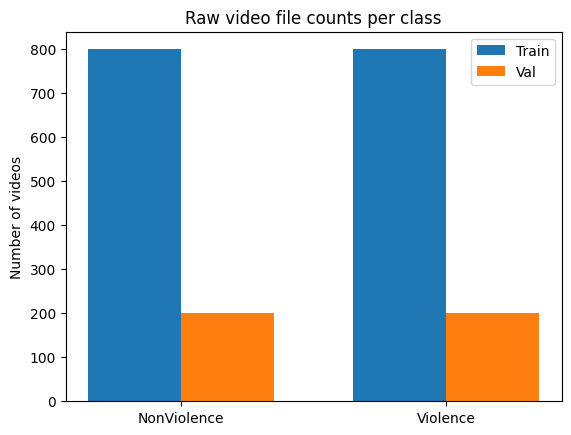

In [8]:
# count_videos.py
import os, glob, matplotlib.pyplot as plt

# path to your raw dataset (adjust if different)
DATASET_PATH = r"D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000"

splits = ["Train", "val"]   # adjust if you also have "Test"
classes = ["NonViolence", "Violence"]

counts = {split: {} for split in splits}

for split in splits:
    for cls in classes:
        folder = os.path.join(DATASET_PATH, split, cls)
        vids = glob.glob(os.path.join(folder, "*.mp4")) \
             + glob.glob(os.path.join(folder, "*.avi")) \
             + glob.glob(os.path.join(folder, "*.mov")) \
             + glob.glob(os.path.join(folder, "*.mkv"))
        counts[split][cls] = len(vids)
        print(f"{split}/{cls}: {len(vids)} videos")

# --- Visualization ---
labels = classes
x = range(len(labels))

fig, ax = plt.subplots()
width = 0.35
ax.bar([i - width/2 for i in x], [counts["Train"][cls] for cls in labels], width, label='Train')
ax.bar([i + width/2 for i in x], [counts["val"][cls] for cls in labels], width, label='Val')

ax.set_ylabel('Number of videos')
ax.set_title('Raw video file counts per class')
ax.set_xticks(list(x))
ax.set_xticklabels(labels)
ax.legend()
plt.show()


Train/NonViolence: 1600 videos
Train/Violence: 1600 videos
val/NonViolence: 400 videos
val/Violence: 400 videos


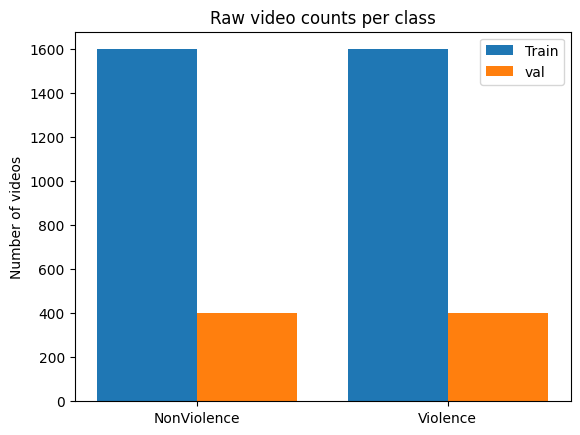

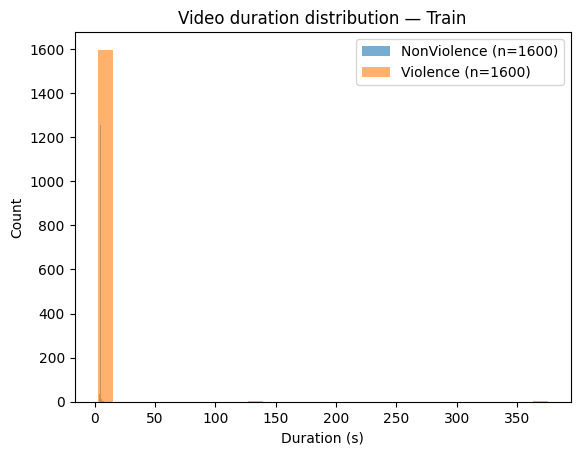

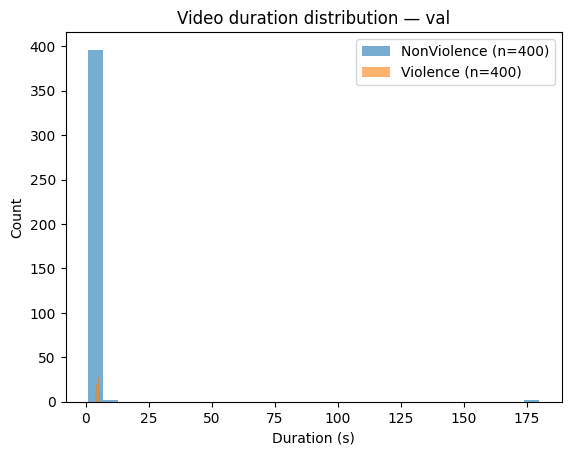

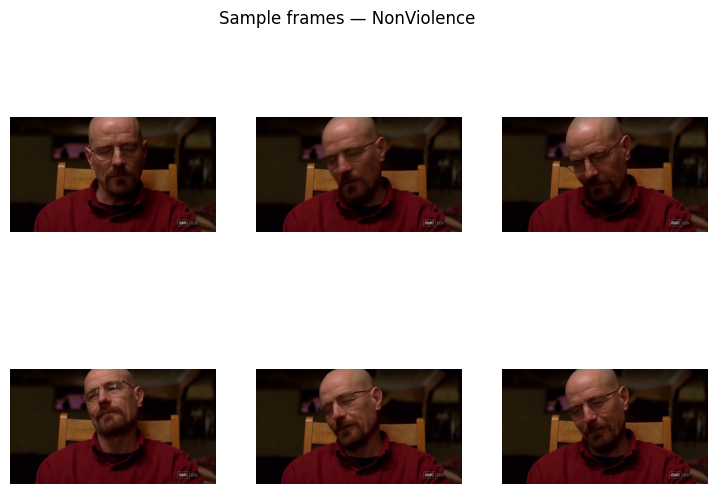

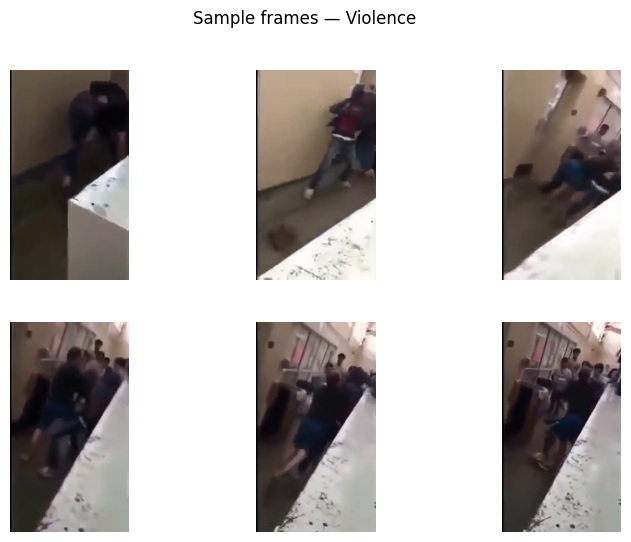

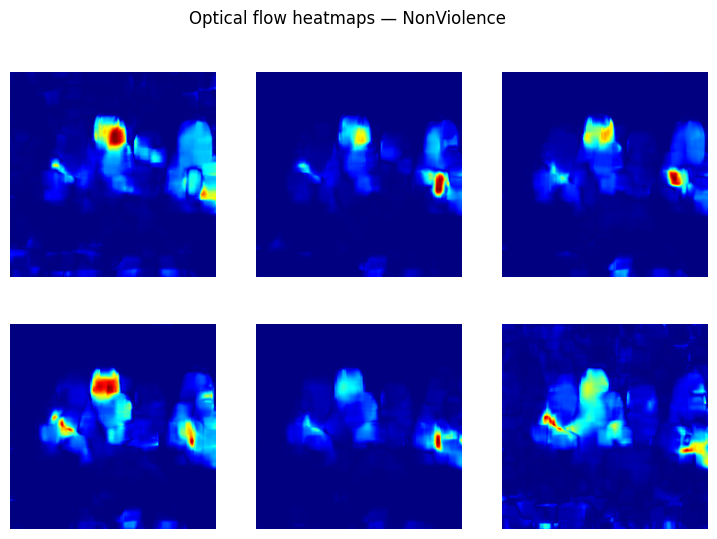

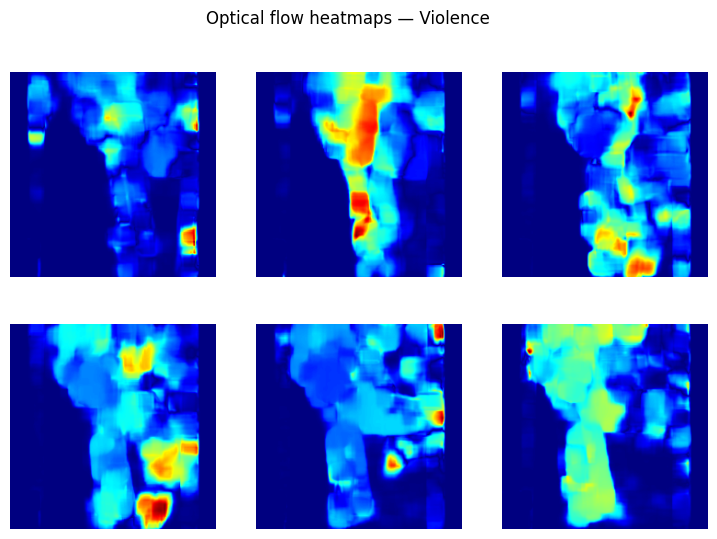

In [9]:
import os, glob, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# ========= CONFIG =========
DATASET_PATH = r"D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000"  # <- change if needed
SPLITS       = ["Train", "val"]            # add "Test" if present
CLASSES      = ["NonViolence", "Violence"]
EXTS         = ("*.mp4","*.avi","*.mov","*.mkv","*.MP4","*.AVI","*.MOV","*.MKV")

# ========= HELPERS =========
def list_videos(root_dir, split, cls):
    vids = []
    base = os.path.join(root_dir, split, cls)
    for pat in EXTS:
        vids += glob.glob(os.path.join(base, pat))
    return sorted(vids)

def read_duration_sec(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    cap.release()
    return fps, frames / max(fps, 1e-6)

def sample_frames(video_path, num_frames=6):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    idxs = np.linspace(0, max(total-1,0), num=num_frames, dtype=int)
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(i))
        ok, fr = cap.read()
        if ok: frames.append(cv2.cvtColor(fr, cv2.COLOR_BGR2RGB))
    cap.release()
    return frames

def optical_flow_heatmaps(video_path, step=2, max_pairs=6, resize_to=224):
    cap = cv2.VideoCapture(video_path)
    ok, prev = cap.read()
    if not ok: return []
    prev = cv2.resize(prev, (resize_to, resize_to))
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    heats = []
    while len(heats) < max_pairs:
        for _ in range(step-1): cap.read()
        ok, nxt = cap.read()
        if not ok: break
        nxt = cv2.resize(nxt, (resize_to, resize_to))
        nxt_gray = cv2.cvtColor(nxt, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, nxt_gray,
                                            None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, _ = cv2.cartToPolar(flow[...,0], flow[...,1])
        mag_norm = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        heat = cv2.applyColorMap(mag_norm, cv2.COLORMAP_JET)
        heats.append(cv2.cvtColor(heat, cv2.COLOR_BGR2RGB))
        prev_gray = nxt_gray
    cap.release()
    return heats

# ========= 1) COUNTS =========
counts = {s: {c: len(list_videos(DATASET_PATH, s, c)) for c in CLASSES} for s in SPLITS}
for s in SPLITS:
    for c in CLASSES:
        print(f"{s}/{c}: {counts[s][c]} videos")

labels = CLASSES
x = np.arange(len(labels))
width = 0.8 / max(1, len(SPLITS))
fig, ax = plt.subplots()
for i, s in enumerate(SPLITS):
    ax.bar(x + (i - (len(SPLITS)-1)/2)*width,
           [counts[s][c] for c in labels], width, label=s)
ax.set_ylabel('Number of videos')
ax.set_title('Raw video counts per class')
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.legend(); plt.show()

# ========= 2) DURATION HISTOGRAMS =========
for s in SPLITS:
    fig, ax = plt.subplots()
    for c in CLASSES:
        durs = []
        for vp in list_videos(DATASET_PATH, s, c):
            fps, dur = read_duration_sec(vp)
            if dur: durs.append(dur)
        if durs:
            ax.hist(durs, bins=30, alpha=0.6, label=f"{c} (n={len(durs)})")
    ax.set_xlabel("Duration (s)"); ax.set_ylabel("Count")
    ax.set_title(f"Video duration distribution — {s}")
    ax.legend(); plt.show()

# ========= 3) FRAME MONTAGE =========
for cls in CLASSES:
    vids = []
    for s in SPLITS: vids += list_videos(DATASET_PATH, s, cls)
    if not vids: continue
    frames = sample_frames(random.choice(vids), num_frames=6)
    if frames:
        fig, axs = plt.subplots(2,3,figsize=(9,6))
        for i, ax in enumerate(axs.flatten()):
            if i < len(frames): ax.imshow(frames[i])
            ax.axis('off')
        fig.suptitle(f"Sample frames — {cls}")
        plt.show()

# ========= 4) OPTICAL FLOW HEATMAPS =========
for cls in CLASSES:
    vids = []
    for s in SPLITS: vids += list_videos(DATASET_PATH, s, cls)
    if not vids: continue
    heats = optical_flow_heatmaps(random.choice(vids))
    if heats:
        fig, axs = plt.subplots(2,3,figsize=(9,6))
        for i, ax in enumerate(axs.flatten()):
            if i < len(heats): ax.imshow(heats[i])
            ax.axis('off')
        fig.suptitle(f"Optical flow heatmaps — {cls}")
        plt.show()


Sampled videos per class:
  NonViolence: 12 videos
  Violence: 12 videos
NonViolence: frames used = 120
Violence: frames used = 120


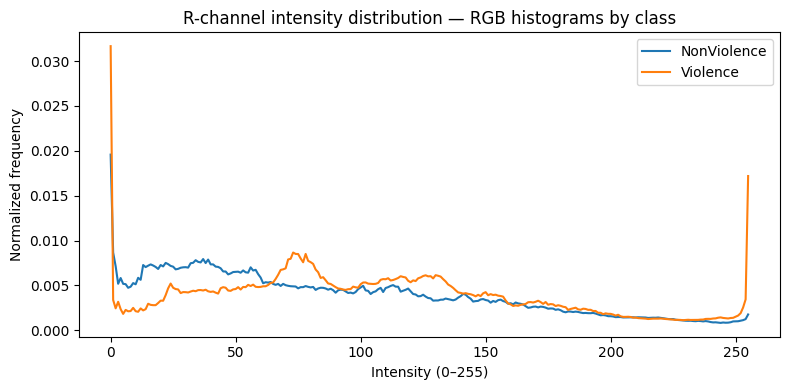

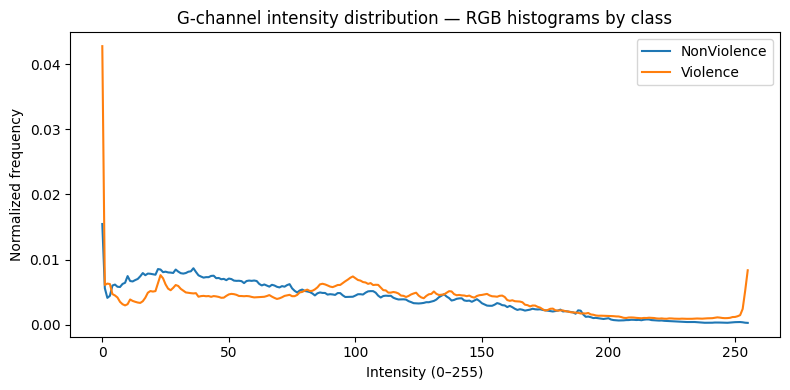

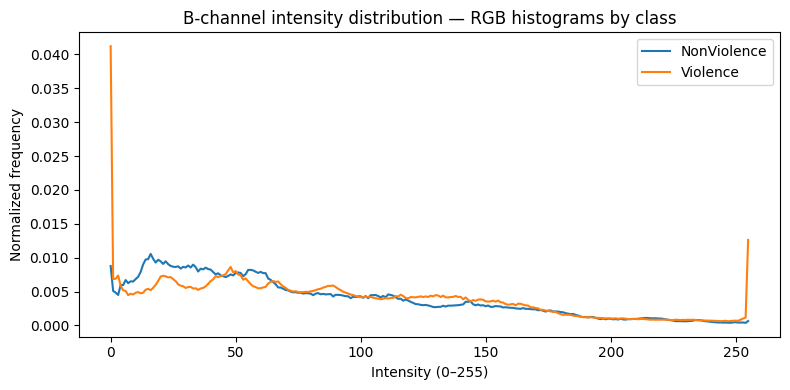

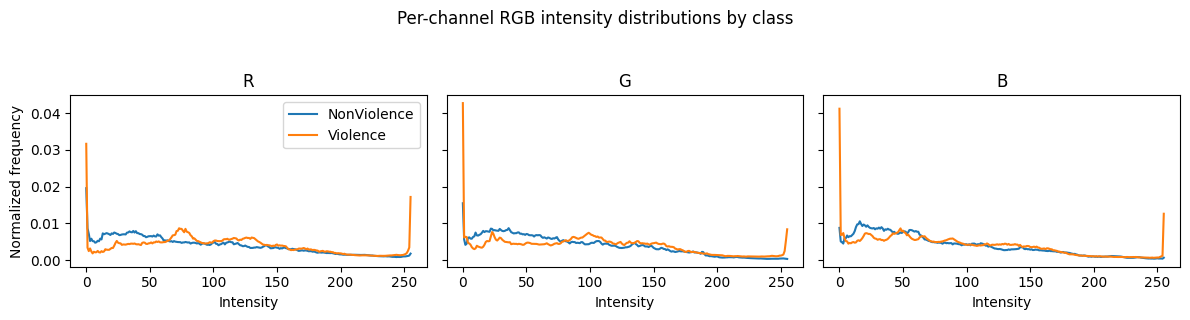

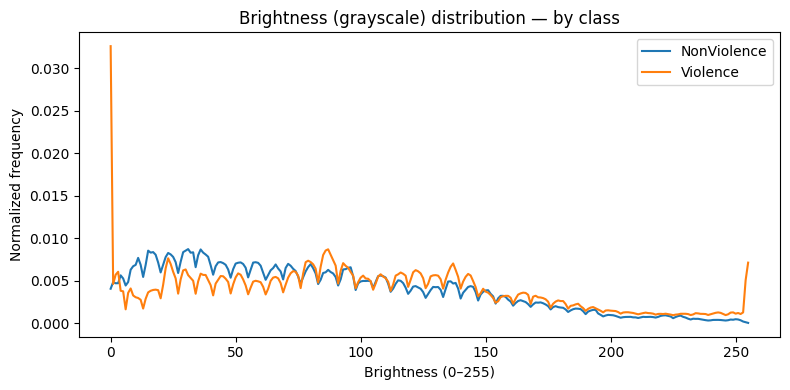

In [10]:
import os, glob, cv2, math, random
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
DATASET_PATH = r"D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000"  # change if needed
SPLITS       = ["Train", "val"]   # add "Test" if you want
CLASSES      = ["NonViolence", "Violence"]

VIDEOS_PER_CLASS   = 12   # how many videos to sample per class (across all SPLITS)
FRAMES_PER_VIDEO   = 10   # how many frames to sample per video
FRAME_RESIZE_TO    = 256  # shorter side resize for speed (None to keep original)
SEED               = 42

random.seed(SEED)
np.random.seed(SEED)

# ---------- HELPERS ----------
EXTS = ("*.mp4","*.avi","*.mov","*.mkv","*.MP4","*.AVI","*.MOV","*.MKV")

def list_videos(root_dir, split, cls):
    base = os.path.join(root_dir, split, cls)
    vids = []
    for pat in EXTS:
        vids += glob.glob(os.path.join(base, pat))
    return sorted(vids)

def sample_uniform_indices(n_frames, k):
    if n_frames <= 0: return []
    k = min(k, n_frames)
    return np.linspace(0, n_frames-1, num=k, dtype=int).tolist()

def read_sampled_frames(video_path, k_frames=8, resize_to=256):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    idxs = sample_uniform_indices(total, k_frames)
    frames = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, fr = cap.read()
        if not ok: 
            continue
        if resize_to:
            h, w = fr.shape[:2]
            if h < w:
                new_h = resize_to
                new_w = int(w * (resize_to / h))
            else:
                new_w = resize_to
                new_h = int(h * (resize_to / w))
            fr = cv2.resize(fr, (new_w, new_h), interpolation=cv2.INTER_AREA)
        frames.append(fr)
    cap.release()
    return frames

def rgb_histograms(frames, bins=256):
    """
    Returns averaged histograms for R, G, B and grayscale intensity.
    Each histogram is length 'bins' and L1-normalized to sum to 1.
    """
    if not frames: 
        return None
    r_acc = np.zeros(bins, dtype=np.float64)
    g_acc = np.zeros(bins, dtype=np.float64)
    b_acc = np.zeros(bins, dtype=np.float64)
    y_acc = np.zeros(bins, dtype=np.float64)  # grayscale/brightness

    for fr in frames:
        # OpenCV is BGR
        b, g, r = cv2.split(fr)
        # per-frame hist (0..255)
        rh, _ = np.histogram(r, bins=bins, range=(0,255))
        gh, _ = np.histogram(g, bins=bins, range=(0,255))
        bh, _ = np.histogram(b, bins=bins, range=(0,255))
        gray = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        yh, _ = np.histogram(gray, bins=bins, range=(0,255))
        r_acc += rh; g_acc += gh; b_acc += bh; y_acc += yh

    # L1-normalize (sum to 1)
    def norm(h):
        s = h.sum()
        return (h / s) if s > 0 else h
    return norm(r_acc), norm(g_acc), norm(b_acc), norm(y_acc)

# ---------- COLLECT SAMPLES ----------
picked = {cls: [] for cls in CLASSES}
for cls in CLASSES:
    all_vids = []
    for sp in SPLITS:
        all_vids += list_videos(DATASET_PATH, sp, cls)
    random.shuffle(all_vids)
    picked[cls] = all_vids[:VIDEOS_PER_CLASS]

print("Sampled videos per class:")
for cls in CLASSES:
    print(f"  {cls}: {len(picked[cls])} videos")

# ---------- COMPUTE HISTOGRAMS ----------
H = {}  # cls -> dict of arrays
for cls in CLASSES:
    all_frames = []
    for vp in picked[cls]:
        frames = read_sampled_frames(vp, k_frames=FRAMES_PER_VIDEO, resize_to=FRAME_RESIZE_TO)
        all_frames.extend(frames)
    res = rgb_histograms(all_frames, bins=256)
    if res is None:
        print(f"[warn] no frames for {cls}")
        continue
    R, G, B, Y = res
    H[cls] = {"R":R, "G":G, "B":B, "Y":Y}
    print(f"{cls}: frames used = {len(all_frames)}")

# ---------- PLOT: RGB OVERLAYS ----------
x = np.arange(256)

def plot_overlay(channel_key, title_suffix):
    plt.figure(figsize=(8,4))
    for cls in CLASSES:
        if cls in H:
            plt.plot(x, H[cls][channel_key], label=cls)
    plt.xlabel("Intensity (0–255)")
    plt.ylabel("Normalized frequency")
    plt.title(f"{channel_key}-channel intensity distribution — {title_suffix}")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_overlay("R", "RGB histograms by class")
plot_overlay("G", "RGB histograms by class")
plot_overlay("B", "RGB histograms by class")

# ---------- PLOT: COMBINED RGB (stacked subplots) ----------
fig, axs = plt.subplots(1,3, figsize=(12,3), sharey=True)
for j, ch in enumerate(["R","G","B"]):
    for cls in CLASSES:
        if cls in H:
            axs[j].plot(x, H[cls][ch], label=cls)
    axs[j].set_title(ch)
    axs[j].set_xlabel("Intensity")
axs[0].set_ylabel("Normalized frequency")
axs[0].legend()
fig.suptitle("Per-channel RGB intensity distributions by class", y=1.05)
plt.tight_layout()
plt.show()

# ---------- PLOT: GRAYSCALE/BRIGHTNESS ----------
plt.figure(figsize=(8,4))
for cls in CLASSES:
    if cls in H:
        plt.plot(x, H[cls]["Y"], label=cls)
plt.xlabel("Brightness (0–255)")
plt.ylabel("Normalized frequency")
plt.title("Brightness (grayscale) distribution — by class")
plt.legend()
plt.tight_layout()
plt.show()


Overall counts: {'NonViolence': 2000, 'Violence': 2000}


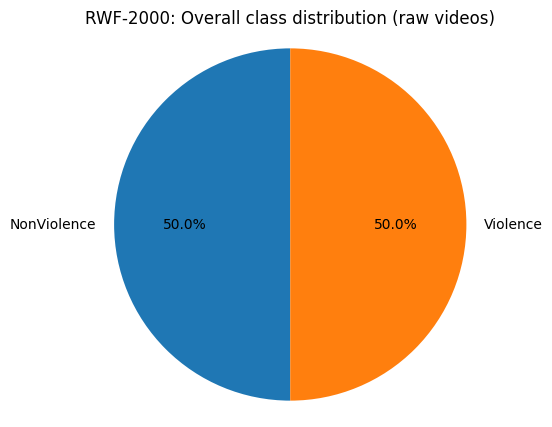

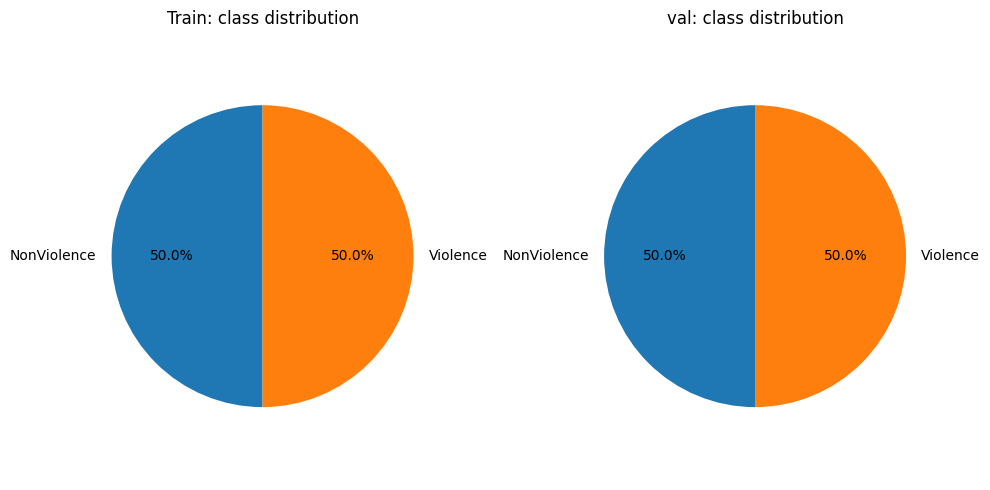

Train: NonViolence=1600 | Violence=1600
val: NonViolence=400 | Violence=400


In [11]:
# Pie charts of class distribution in RWF2000 (raw videos)
import os, glob, matplotlib.pyplot as plt

# --- CONFIG: point to your RWF2000 root (the one with Train/ and val/ folders) ---
RWF_ROOT = r"D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000"
SPLITS   = ["Train", "val", "Test"]   # keep only those you actually have
CLASSES  = ["NonViolence", "Violence"]
EXTS     = ("*.mp4","*.avi","*.mov","*.mkv","*.MP4","*.AVI","*.MOV","*.MKV")

def count_videos(folder):
    n = 0
    for pat in EXTS:
        n += len(glob.glob(os.path.join(folder, pat)))
    return n

# counts[split][class] = count
counts = {s: {c: 0 for c in CLASSES} for s in SPLITS}
for s in SPLITS:
    split_ok = False
    for c in CLASSES:
        d = os.path.join(RWF_ROOT, s, c)
        if os.path.isdir(d):
            split_ok = True
            counts[s][c] = count_videos(d)
    if not split_ok:
        counts.pop(s, None)  # remove splits that don't exist

# --- Overall pie (across available splits) ---
overall = {c: 0 for c in CLASSES}
for s in counts:
    for c in CLASSES:
        overall[c] += counts[s][c]

print("Overall counts:", overall)
plt.figure(figsize=(5,5))
plt.pie(list(overall.values()),
        labels=CLASSES,
        autopct="%1.1f%%",
        startangle=90)
plt.title("RWF-2000: Overall class distribution (raw videos)")
plt.axis('equal')
plt.show()

# --- Per-split pies ---
n_splits = len(counts)
if n_splits > 0:
    fig, axes = plt.subplots(1, n_splits, figsize=(5*n_splits, 5))
    if n_splits == 1:
        axes = [axes]
    for ax, s in zip(axes, counts.keys()):
        vals = [counts[s][c] for c in CLASSES]
        ax.pie(vals, labels=CLASSES, autopct="%1.1f%%", startangle=90)
        ax.set_title(f"{s}: class distribution")
        ax.axis('equal')
    plt.tight_layout()
    plt.show()

# (Optional) print exact numbers
for s in counts:
    print(f"{s}: NonViolence={counts[s]['NonViolence']} | Violence={counts[s]['Violence']}")


## PMC DATASET

Raw video file counts:
  Non-violent: 240
  Violent    : 460
  NonViolent / cam1: 120
  NonViolent / cam2: 120
  Violent / cam1: 230
  Violent / cam2: 230


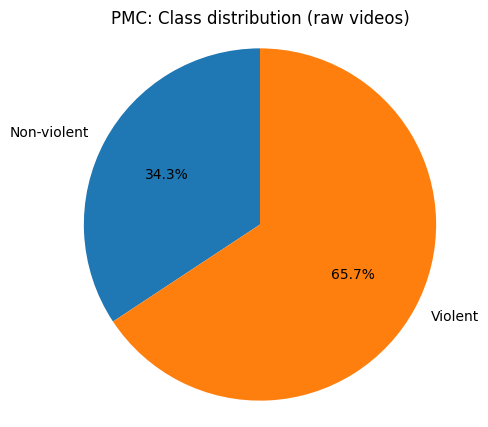

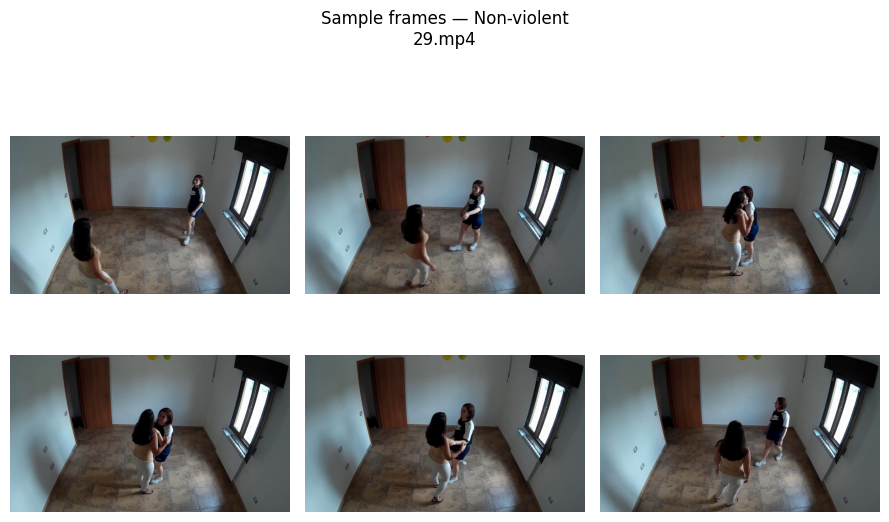

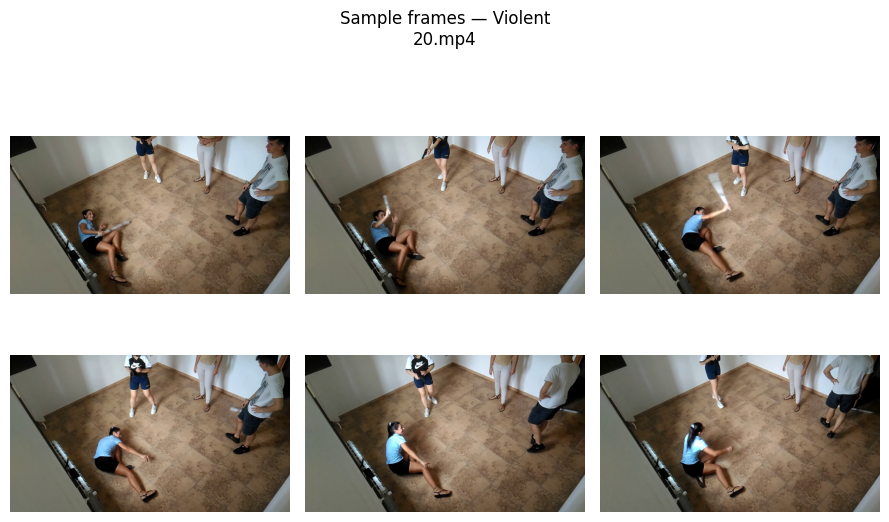

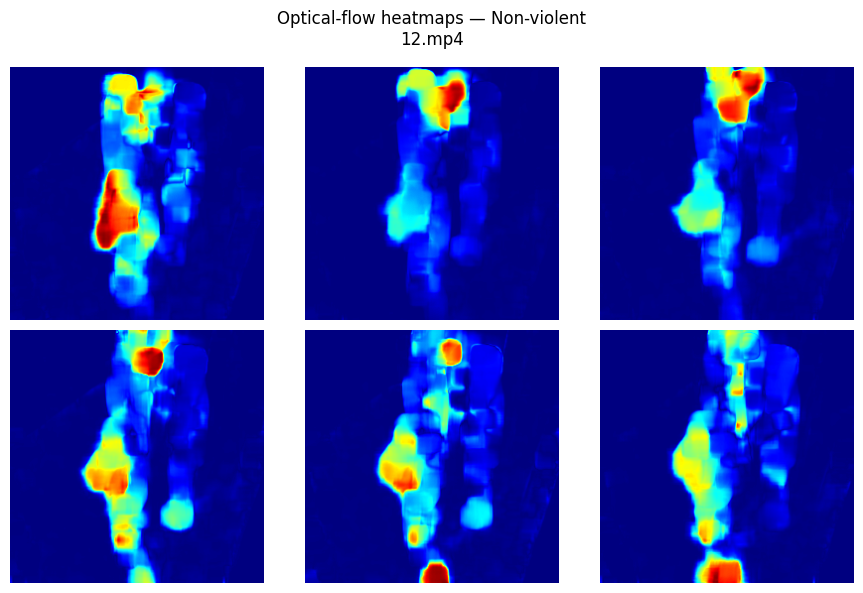

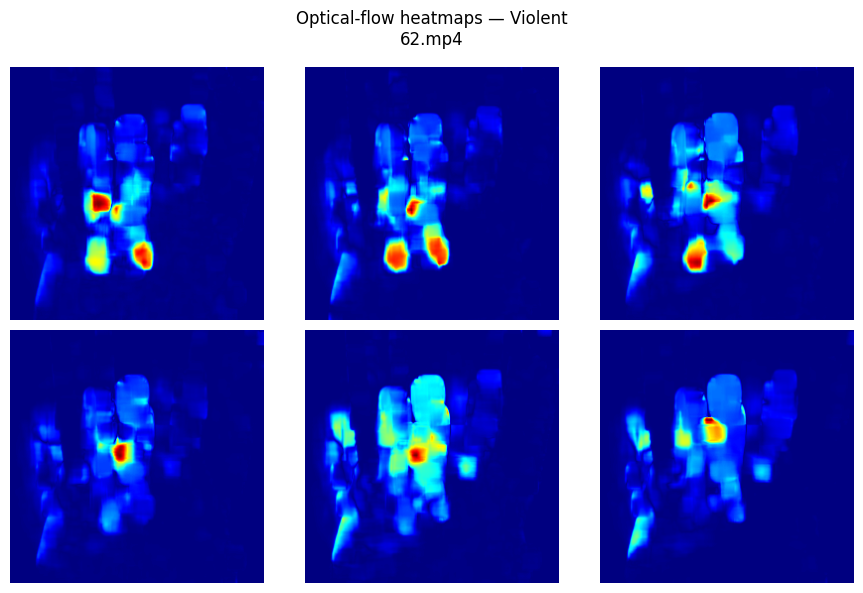

In [12]:
# === Visualization for "violence-detection-pmc" dataset ===
import os, glob, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG: set this to your path ----------
PMC_ROOT = r"D:\SEM2\AML\SafeVisionAIML\Data\Video\violence-detection-pmc"

CLASSES = {"non-violent":"NonViolent", "violent":"Violent"}  # readable labels
EXTS = ("*.mp4","*.avi","*.mov","*.mkv","*.MP4","*.AVI","*.MOV","*.MKV")
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ---------- Helpers ----------
def list_videos_class(root, class_dir):
    """Return list of absolute video paths under class_dir (recurses cam1/cam2/...)."""
    vids = []
    base = os.path.join(root, class_dir)
    for cam in os.listdir(base) if os.path.isdir(base) else []:
        cam_path = os.path.join(base, cam)
        if not os.path.isdir(cam_path): 
            continue
        for pat in EXTS:
            vids += glob.glob(os.path.join(cam_path, pat))
    return sorted(vids)

def read_duration_sec(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened(): 
        return None
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    cap.release()
    return frames / max(fps, 1e-6)

def sample_frames(video_path, num_frames=6):
    """Return up to num_frames RGB frames uniformly from a video."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    if not cap.isOpened():
        return frames
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    if total <= 0:
        cap.release(); return frames
    idxs = np.linspace(0, total-1, num=num_frames, dtype=int)
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(i))
        ok, fr = cap.read()
        if ok:
            frames.append(cv2.cvtColor(fr, cv2.COLOR_BGR2RGB))
    cap.release()
    return frames

def optical_flow_heatmaps(video_path, step=2, max_pairs=6, resize_to=224):
    """Return a list of RGB heatmaps of flow magnitude between successive frames."""
    cap = cv2.VideoCapture(video_path)
    heats = []
    ok, prev = cap.read()
    if not ok:
        cap.release(); return heats
    prev = cv2.resize(prev, (resize_to, resize_to))
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    while len(heats) < max_pairs:
        # skip 'step-1' frames to reduce correlation
        for _ in range(max(step-1,0)):
            if not cap.read()[0]: break
        ok, nxt = cap.read()
        if not ok: break
        nxt = cv2.resize(nxt, (resize_to, resize_to))
        nxt_gray = cv2.cvtColor(nxt, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prev_gray, nxt_gray,
                                            None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, _ = cv2.cartToPolar(flow[...,0], flow[...,1])
        mag_norm = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        heat_bgr = cv2.applyColorMap(mag_norm, cv2.COLORMAP_JET)
        heats.append(cv2.cvtColor(heat_bgr, cv2.COLOR_BGR2RGB))
        prev_gray = nxt_gray
    cap.release()
    return heats

# ---------- 1) Counts + pie chart ----------
vids_non = list_videos_class(PMC_ROOT, "non-violent")
vids_viol = list_videos_class(PMC_ROOT, "violent")

counts = {"NonViolent": len(vids_non), "Violent": len(vids_viol)}
print("Raw video file counts:")
print(f"  Non-violent: {counts['NonViolent']}")
print(f"  Violent    : {counts['Violent']}")

# per-camera counts (optional detail)
for cls_folder, nice in (("non-violent","NonViolent"), ("violent","Violent")):
    base = os.path.join(PMC_ROOT, cls_folder)
    if os.path.isdir(base):
        for cam in sorted(os.listdir(base)):
            cam_dir = os.path.join(base, cam)
            if not os.path.isdir(cam_dir): continue
            n = sum(len(glob.glob(os.path.join(cam_dir, pat))) for pat in EXTS)
            print(f"  {nice} / {cam}: {n}")

# Pie chart
plt.figure(figsize=(5,5))
plt.pie([counts["NonViolent"], counts["Violent"]],
        labels=["Non-violent","Violent"],
        autopct="%1.1f%%", startangle=90)
plt.title("PMC: Class distribution (raw videos)")
plt.axis('equal')
plt.show()

# ---------- 2) Sample frame montage (one random video per class) ----------
for cls_name, nice in (("non-violent","Non-violent"), ("violent","Violent")):
    vids = list_videos_class(PMC_ROOT, cls_name)
    if not vids:
        print(f"[warn] no videos for {cls_name}")
        continue
    pick = random.choice(vids)
    frames = sample_frames(pick, num_frames=6)
    if not frames:
        print(f"[warn] could not read frames: {pick}")
        continue
    fig, axs = plt.subplots(2,3, figsize=(9,6))
    for i, ax in enumerate(axs.flatten()):
        if i < len(frames):
            ax.imshow(frames[i])
        ax.axis('off')
    fig.suptitle(f"Sample frames — {nice}\n{os.path.basename(pick)}", y=0.98)
    plt.tight_layout()
    plt.show()

# ---------- 3) Optical-flow heatmaps (one random video per class) ----------
for cls_name, nice in (("non-violent","Non-violent"), ("violent","Violent")):
    vids = list_videos_class(PMC_ROOT, cls_name)
    if not vids:
        continue
    pick = random.choice(vids)
    heats = optical_flow_heatmaps(pick, step=2, max_pairs=6, resize_to=256)
    if not heats:
        print(f"[warn] no flow for {pick}")
        continue
    fig, axs = plt.subplots(2,3, figsize=(9,6))
    for i, ax in enumerate(axs.flatten()):
        if i < len(heats):
            ax.imshow(heats[i])
        ax.axis('off')
    fig.suptitle(f"Optical-flow heatmaps — {nice}\n{os.path.basename(pick)}", y=0.98)
    plt.tight_layout()
    plt.show()


Video counts: {'non-violent': 240, 'violent': 460}


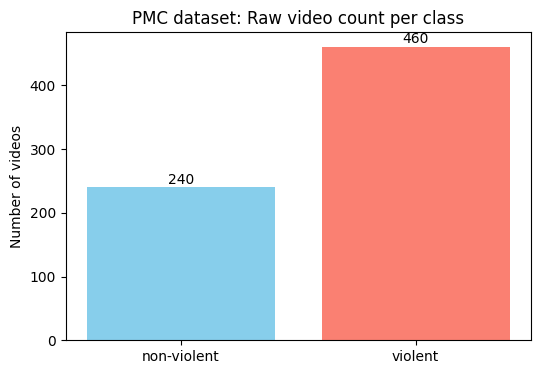

In [13]:
import os, glob
import matplotlib.pyplot as plt

# --- CONFIG: point to your dataset root ---
PMC_ROOT = r"D:\SEM2\AML\SafeVisionAIML\Data\Video\violence-detection-pmc"
CLASSES = ["non-violent", "violent"]
EXTS = ("*.mp4","*.avi","*.mov","*.mkv","*.MP4","*.AVI","*.MOV","*.MKV")

def count_videos(folder):
    n = 0
    for pat in EXTS:
        n += len(glob.glob(os.path.join(folder, "**", pat), recursive=True))
    return n

counts = {}
for cls in CLASSES:
    counts[cls] = count_videos(os.path.join(PMC_ROOT, cls))

print("Video counts:", counts)

# --- Bar chart ---
plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values(), color=["skyblue","salmon"])
plt.ylabel("Number of videos")
plt.title("PMC dataset: Raw video count per class")
for i, (cls, val) in enumerate(counts.items()):
    plt.text(i, val+1, str(val), ha="center", va="bottom", fontsize=10)
plt.show()


## SCVD

Video counts:
Train: {'Normal': 400, 'Violence': 198, 'Weaponized': 200}
Test: {'Normal': 92, 'Violence': 24, 'Weaponized': 48}


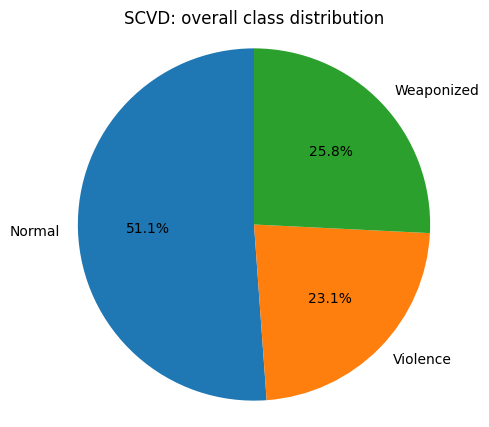

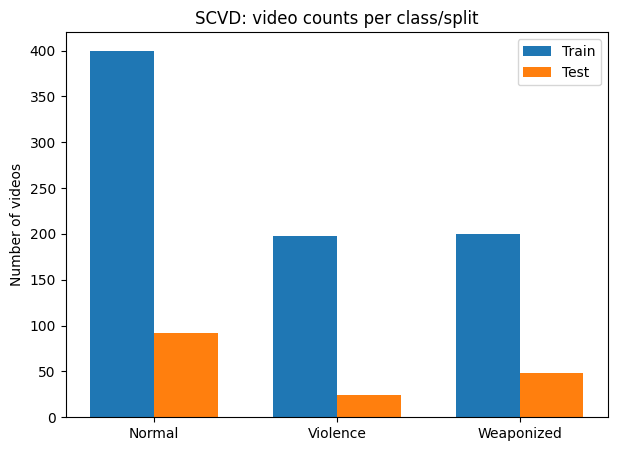

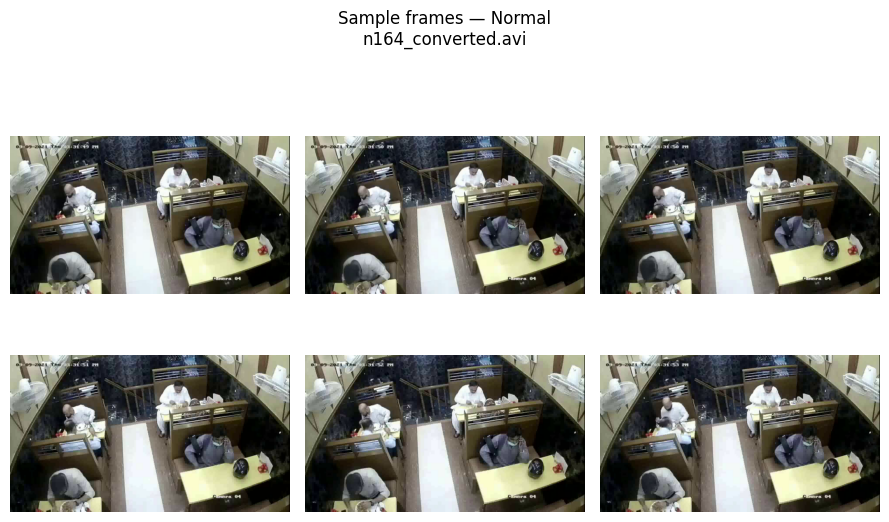

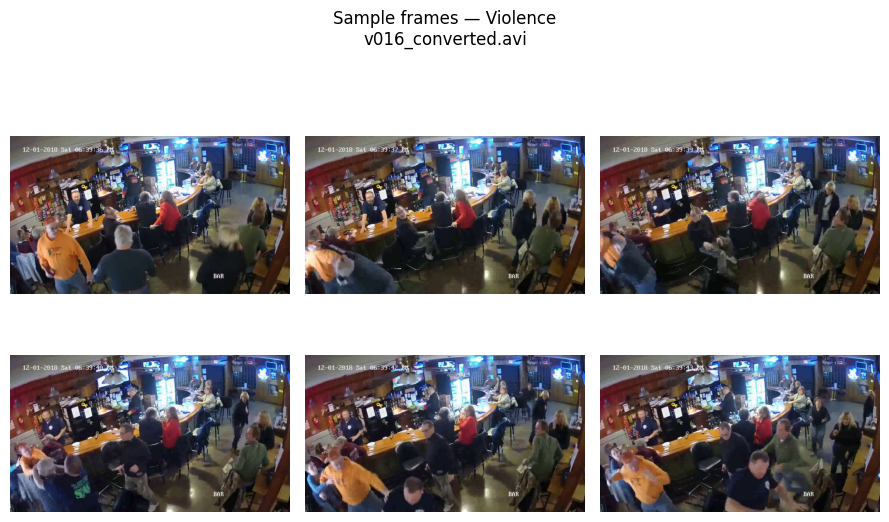

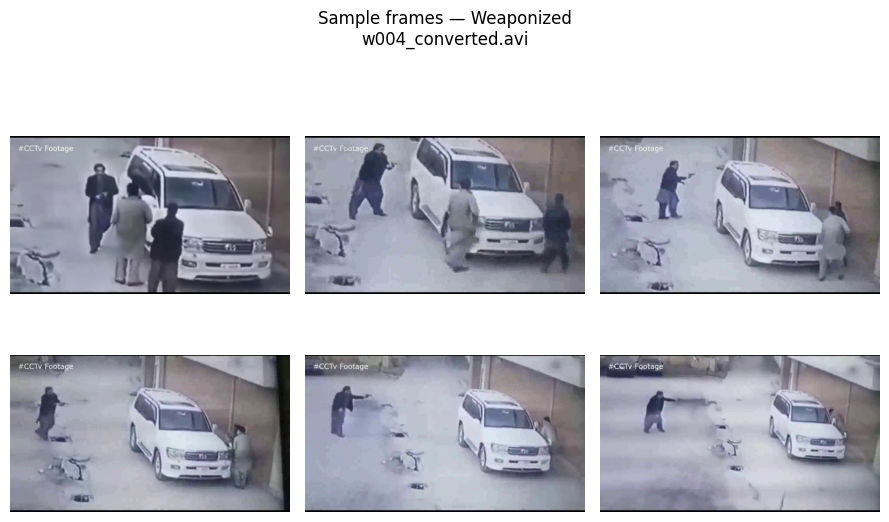

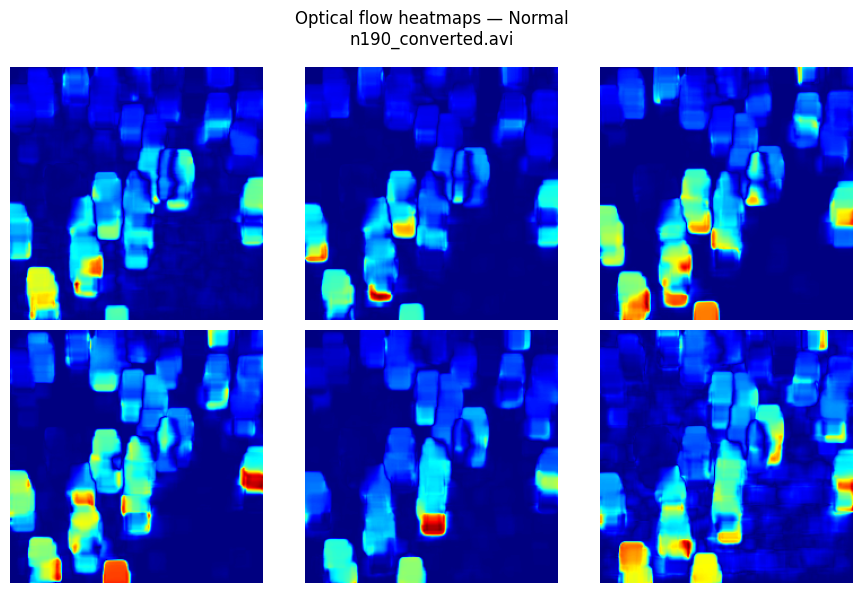

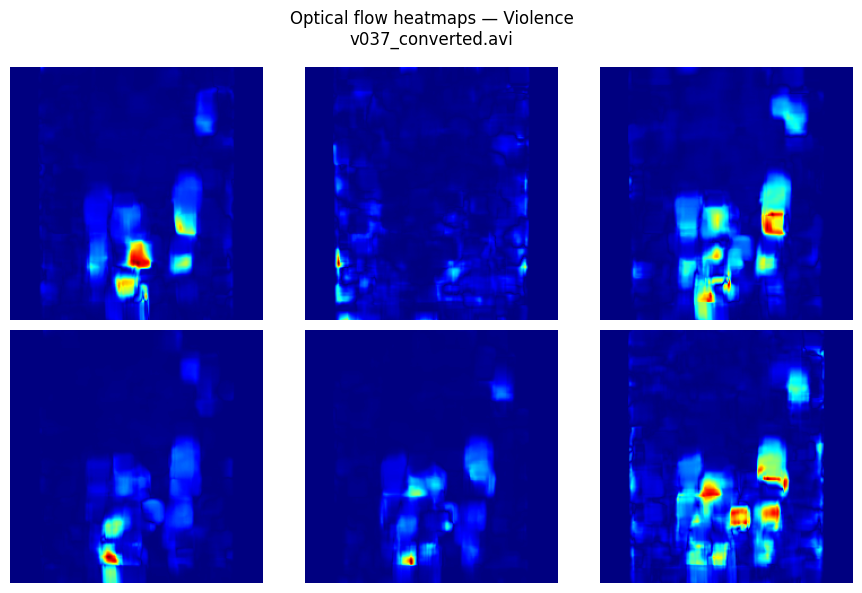

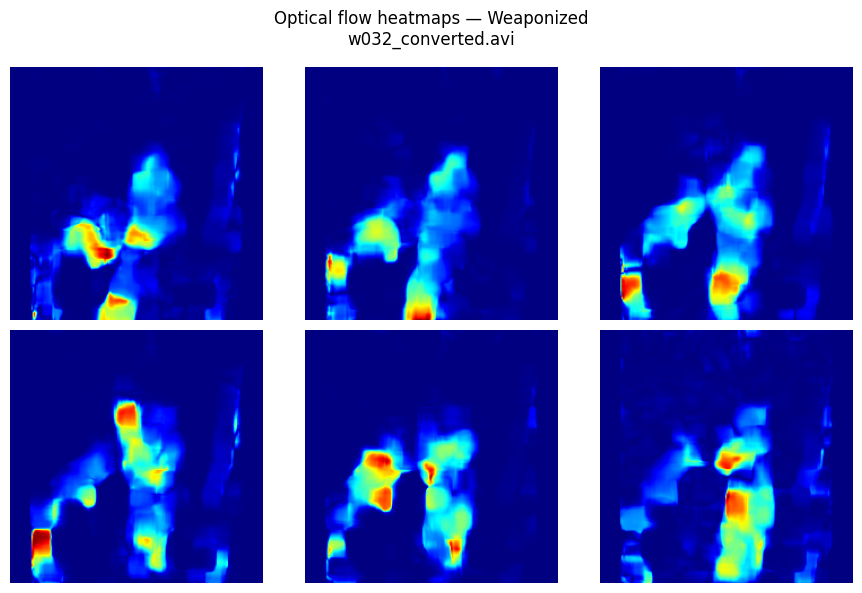

In [14]:
# === Visualization for SCVD dataset (raw videos) ===
import os, glob, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# -------- CONFIG --------
SCVD_ROOT = r"D:\SEM2\AML\SafeVisionAIML\Data\Video\SCVD\SCVD_converted"  # adjust path
SPLITS = ["Train", "Test"]
CLASSES = ["Normal", "Violence", "Weaponized"]
EXTS = ("*.mp4","*.avi","*.mov","*.mkv","*.MP4","*.AVI","*.MOV","*.MKV")
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# -------- Helpers --------
def list_videos(root, split, cls):
    base = os.path.join(root, split, cls)
    vids = []
    for pat in EXTS:
        vids += glob.glob(os.path.join(base, pat))
    return sorted(vids)

def sample_frames(video_path, num_frames=6):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    if total <= 0: return frames
    idxs = np.linspace(0, total-1, num=num_frames, dtype=int)
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(i))
        ok, fr = cap.read()
        if ok:
            frames.append(cv2.cvtColor(fr, cv2.COLOR_BGR2RGB))
    cap.release()
    return frames

def optical_flow_heatmaps(video_path, step=2, max_pairs=6, resize_to=224):
    cap = cv2.VideoCapture(video_path)
    heats = []
    ok, prev = cap.read()
    if not ok: return heats
    prev = cv2.resize(prev, (resize_to, resize_to))
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    while len(heats) < max_pairs:
        for _ in range(max(step-1,0)):
            if not cap.read()[0]: break
        ok, nxt = cap.read()
        if not ok: break
        nxt = cv2.resize(nxt, (resize_to, resize_to))
        nxt_gray = cv2.cvtColor(nxt, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prev_gray, nxt_gray,
                                            None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, _ = cv2.cartToPolar(flow[...,0], flow[...,1])
        mag_norm = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        heat_bgr = cv2.applyColorMap(mag_norm, cv2.COLORMAP_JET)
        heats.append(cv2.cvtColor(heat_bgr, cv2.COLOR_BGR2RGB))
        prev_gray = nxt_gray
    cap.release()
    return heats

# -------- 1) Counts + Charts --------
counts = {s: {c: len(list_videos(SCVD_ROOT,s,c)) for c in CLASSES} for s in SPLITS}

print("Video counts:")
for s in SPLITS:
    print(f"{s}: {counts[s]}")

# overall
overall = {c:0 for c in CLASSES}
for s in SPLITS:
    for c in CLASSES:
        overall[c] += counts[s][c]

# Pie (overall)
plt.figure(figsize=(5,5))
plt.pie(list(overall.values()), labels=CLASSES,
        autopct="%1.1f%%", startangle=90)
plt.title("SCVD: overall class distribution")
plt.axis("equal")
plt.show()

# Bar chart (per split)
x = np.arange(len(CLASSES))
width = 0.35
fig, ax = plt.subplots(figsize=(7,5))
for i, s in enumerate(SPLITS):
    vals = [counts[s][c] for c in CLASSES]
    ax.bar(x + (i-0.5)*width, vals, width, label=s)
ax.set_xticks(x); ax.set_xticklabels(CLASSES)
ax.set_ylabel("Number of videos")
ax.set_title("SCVD: video counts per class/split")
ax.legend()
plt.show()

# -------- 2) Sample frames montage --------
for cls in CLASSES:
    vids = []
    for s in SPLITS: vids += list_videos(SCVD_ROOT, s, cls)
    if not vids: continue
    pick = random.choice(vids)
    frames = sample_frames(pick, num_frames=6)
    if not frames: continue
    fig, axs = plt.subplots(2,3, figsize=(9,6))
    for i, ax in enumerate(axs.flatten()):
        if i < len(frames): ax.imshow(frames[i])
        ax.axis('off')
    fig.suptitle(f"Sample frames — {cls}\n{os.path.basename(pick)}")
    plt.tight_layout(); plt.show()

# -------- 3) Optical flow heatmaps --------
for cls in CLASSES:
    vids = []
    for s in SPLITS: vids += list_videos(SCVD_ROOT, s, cls)
    if not vids: continue
    pick = random.choice(vids)
    heats = optical_flow_heatmaps(pick, step=2, max_pairs=6, resize_to=224)
    if not heats: continue
    fig, axs = plt.subplots(2,3, figsize=(9,6))
    for i, ax in enumerate(axs.flatten()):
        if i < len(heats): ax.imshow(heats[i])
        ax.axis('off')
    fig.suptitle(f"Optical flow heatmaps — {cls}\n{os.path.basename(pick)}")
    plt.tight_layout(); plt.show()


## normalization comparizon


[INFO] RAW video: D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000\Train\Violence\V_1.mp4
[INFO] CLIP frame: D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000_clips\train\Fight\V_1\clip_000\img_000.jpg
[INFO] RAW frame shape: (1080, 1920, 3) | CLIP frame shape: (112, 112, 3)


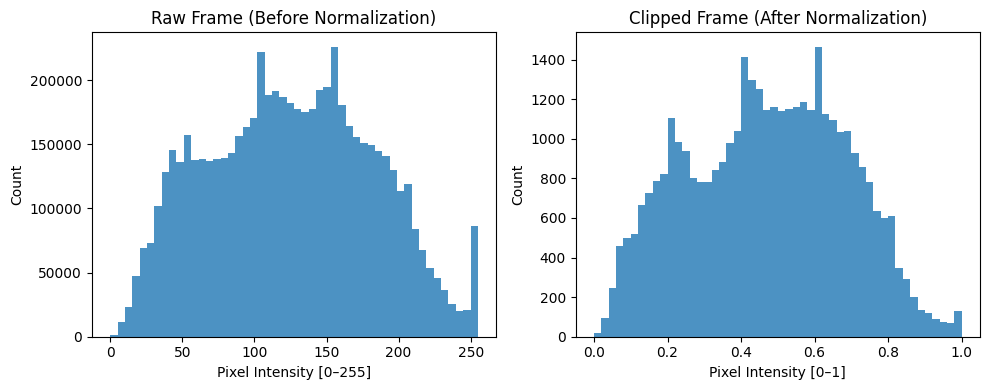

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# -------------------------
# Base paths (adjust only if your root changes)
# -------------------------
BASE = Path(r"D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000")
RAW_TRAIN = BASE / "Train"                 # ...\rwf2000\Train\{Violence, NonViolence}
CLIPS_TRAIN = BASE.parent / "rwf2000_clips" / "train"  # ...\rwf2000_clips\train\{Fight, NonFight}

# -------------------------
# Choose class once; code maps raw↔clips automatically
# Set CLASS_RAW to "Violence" or "NonViolence"
# -------------------------
CLASS_RAW = "Violence"  # or "NonViolence"
CLASS_CLIP = "Fight" if CLASS_RAW == "Violence" else "NonFight"

# -------------------------
# Helper: pick a raw video and a clipped frame
# -------------------------
def pick_one_raw_video(class_raw: str):
    search_dir = RAW_TRAIN / class_raw
    vids = sorted(glob.glob(str(search_dir / "*.mp4")))
    if not vids:
        raise FileNotFoundError(f"No .mp4 found under: {search_dir}")
    return Path(vids[0])

def pick_one_clip_frame(class_clip: str):
    # e.g. ...\rwf2000_clips\train\Fight\V_1\clip_000\img_00001.jpg
    # find first V_* / clip_* / img_*.jpg
    v_dirs = sorted((CLIPS_TRAIN / class_clip).glob("V_*"))
    if not v_dirs:
        raise FileNotFoundError(f"No V_* dirs under: {CLIPS_TRAIN / class_clip}")

    for vdir in v_dirs:
        clip_dirs = sorted(vdir.glob("clip_*"))
        for cdir in clip_dirs:
            imgs = sorted(cdir.glob("img_*.jpg"))
            if imgs:
                return imgs[0]
    raise FileNotFoundError(f"No img_*.jpg found under any clip in: {CLIPS_TRAIN / class_clip}")

# -------------------------
# Extract a representative frame from the raw video
# -------------------------
def read_middle_frame(video_path: Path):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    # pick ~middle frame; fall back to 0 if unknown
    idx = max(frame_count // 2, 0)
    if frame_count > 0:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame_bgr = cap.read()
    cap.release()

    if not ret or frame_bgr is None:
        raise RuntimeError(f"Could not read a frame at index {idx} from: {video_path}")

    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    return frame_rgb

# -------------------------
# Load one clipped frame (already resized in your pipeline)
# -------------------------
def read_clip_frame(img_path: Path):
    img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise RuntimeError(f"Could not read image: {img_path}")
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# -------------------------
# Main: fetch samples, normalize clipped frame, plot histograms
# -------------------------
raw_video = pick_one_raw_video(CLASS_RAW)
clip_img = pick_one_clip_frame(CLASS_CLIP)

raw_frame = read_middle_frame(raw_video)
clip_frame = read_clip_frame(clip_img)

# Normalize clipped frame to [0,1]
clip_frame_norm = clip_frame.astype(np.float32) / 255.0

# Flatten for histograms
pixels_before = raw_frame.flatten()               # 0..255
pixels_after = clip_frame_norm.flatten()          # 0..1

print(f"[INFO] RAW video: {raw_video}")
print(f"[INFO] CLIP frame: {clip_img}")
print(f"[INFO] RAW frame shape: {raw_frame.shape} | CLIP frame shape: {clip_frame.shape}")

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(pixels_before, bins=50, alpha=0.8)
plt.title("Raw Frame (Before Normalization)")
plt.xlabel("Pixel Intensity [0–255]")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(pixels_after, bins=50, alpha=0.8)
plt.title("Clipped Frame (After Normalization)")
plt.xlabel("Pixel Intensity [0–1]")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


## Video -> 2D Tensor sample (we will use 3d)

In [18]:
import cv2
import torch
import numpy as np
from pathlib import Path

# -------------------------
# Pick one clipped frame
# -------------------------
clip_img_path = Path(r"D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000_clips\train\Fight\V_1\clip_000\img_001.jpg")

# Load image (H,W,3) in RGB
img_bgr = cv2.imread(str(clip_img_path))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# -------------------------
# Normalize + Convert to Tensor
# -------------------------
# scale pixel values [0,255] → [0,1]
img_norm = img_rgb.astype(np.float32) / 255.0

# Convert (H,W,C) → (C,H,W) for PyTorch
img_tensor = torch.from_numpy(img_norm).permute(2,0,1)

# Add batch dimension (1,C,H,W)
img_tensor = img_tensor.unsqueeze(0)

# -------------------------
# Print info for demo
# -------------------------
print(f"Image path: {clip_img_path}")
print(f"Original shape: {img_rgb.shape}")     # e.g. (112,112,3)
print(f"Tensor shape: {img_tensor.shape}")    # e.g. (1,3,112,112)
print(f"Tensor dtype: {img_tensor.dtype}, range: [{img_tensor.min().item():.3f}, {img_tensor.max().item():.3f}]")


Image path: D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000_clips\train\Fight\V_1\clip_000\img_001.jpg
Original shape: (112, 112, 3)
Tensor shape: torch.Size([1, 3, 112, 112])
Tensor dtype: torch.float32, range: [0.000, 1.000]


## 3d tensor

In [ ]:
import cv2
import torch
import numpy as np
from pathlib import Path
import glob

# Example clip folder
clip_dir = Path(r"D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000_clips\train\Fight\V_1\clip_000")

# Pick first 16 frames
frames = sorted(glob.glob(str(clip_dir / "img_*.jpg")))[:16]

# Preprocess each frame → tensor (C,H,W)
tensor_frames = []
for f in frames:
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (112,112))  # resize to 112x112 if not already
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img).permute(2,0,1)  # (3,H,W)
    tensor_frames.append(img_tensor)

# Stack into (T,C,H,W) then permute → (C,T,H,W)
video_tensor = torch.stack(tensor_frames, dim=0).permute(1,0,2,3)

# Add batch dimension → (N,C,T,H,W)
video_tensor = video_tensor.unsqueeze(0)

print(f"Image path: {clip_img_path}")
print("Video tensor shape:", video_tensor.shape)

print(f"Original shape: {video_tensor.shape}")     # e.g. (112,112,3)


Image path: D:\SEM2\AML\SafeVisionAIML\Data\Video\rwf2000_clips\train\Fight\V_1\clip_000\img_001.jpg
Video tensor shape: torch.Size([1, 3, 16, 112, 112])
Original shape: torch.Size([1, 3, 16, 112, 112])
Tensor shape: torch.Size([1, 3, 16, 112, 112])
